# Timeseries

---
**Overview.**  We introduce the tools for working with dates, times, and time series data. We start with functionality built into python itself, then discuss how pandas builds on these tools to add powerful time series capabilities to DataFrames.

**Outline**

- [Dates in python](#datetime): covers the basics of working with dates and times in python
- [Dates in pandas](#pandas_dates): shows how to use dates with pandas objects


**Note: requires internet access to run.**  

In order to run the code in this notebook, you will need to have the quandl package installed. You can do this from the command line using

```
pip install quandl --upgrade
```

---

In [1]:
import sys                             # system module
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np
%matplotlib inline    
plt.style.use("ggplot")

# quandl package
import quandl

print('Today: ', dt.date.today())

# helper function to print info about dataframe

def df_info(df):
    print("Shape: ", df.shape)
    print("dtypes: ", df.dtypes.to_dict())
    print("index dtype: ", df.index.dtype)
    return pd.concat([df.head(3), df.tail(3)])

Python version: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.21.0
quandl version:  3.2.1
Today:  2017-12-10


## Quandl <a id=data></a>

[quandl](https://www.quandl.com) is a company that collects and maintains financial and economic data from standard sources (e.g. FRED, IMF, BEA, etc.) and non-standard sources (Fx data, company level data, trader receipts). The data is viewable on their webpage (see [here](https://www.quandl.com/data/BLSN-BLS-International) or [there](https://www.quandl.com/data/USTREASURY-US-Treasury) for examples), but made available to programming languages via their API. We will access their [API](https://www.quandl.com/docs/api#introduction) using their [python library](https://www.quandl.com/tools/python).

Suppose, for example, that we wanted to get data on taxes in the US. Here's how we might find some:

- Open up the quandl [search page](https://www.quandl.com/search)
- Type in ["US tax revenue"](https://www.quandl.com/search)
- Click on [one of the results](https://www.quandl.com/data/OECD/REV_NES_TOTALTAX_TAXUSD_USA-United-States-Total-Total-Tax-Revenue-Total-Tax-Revenue-In-Usd) that seems interesting to us
- Checkout things like the frequency (Annual for this data set), the quandl code (top right, here it is `OECD/REV_NES_TOTALTAX_TAXUSD_USA`) and description.

**Exercise** (5 min): Go to Quandl's website and explore some of the data quandl has available. Come up with 2 datasets and make a dictionary that maps the quandl code into a reasonable name. For example, for the us tax revenue dataset above I could have done

```python
my_data = {"OECD/REV_NES_TOTALTAX_TAXUSD_USA": "US_tax_rev"}
```

We can download the data using the `quandl.get` function and passing it one of the Quandl codes we collected in the previous exercise

In [ ]:
us_tax = quandl.get("OECD/REV_NES_TOTALTAX_TAXUSD_USA")
df_info(us_tax)

We can also pass `start_date` and `end_date` parameters to control the dates for the downloaded data:

In [2]:
us_tax_recent = quandl.get("OECD/REV_NES_TOTALTAX_TAXUSD_USA", start_date="2000-01-01")
df_info(us_tax_recent)

Shape:  (17, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
2000-12-31,2900.519
2001-12-31,2884.730
2002-12-31,2738.000
2014-12-31,4518.356
2015-12-31,4752.409
2016-12-31,4846.313


Now, let's read in the data sets we found were interesting. Feel free to use the codes you looked up, or the ones I'm using here. 

In [10]:
ffr = quandl.get("FRED/DFF")

In [11]:
df_info(ffr)

Shape:  (23171, 1)
dtypes:  {'Value': dtype('float64')}
index dtype:  datetime64[ns]


,Value
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
2017-12-05,1.16
2017-12-06,1.16
2017-12-07,1.16


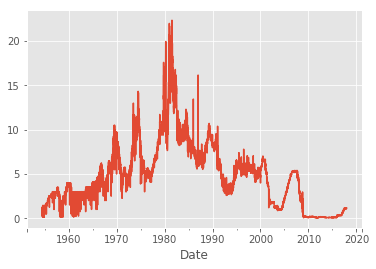

In [19]:
ffr.rename(columns={"Value": "risk_free_rate"}, inplace=True)

ffr.columns

ffr.head()

ffr.risk_free_rate.plot()

So, `"FRED/DFF"` is the [federal funds rate](https://fred.stlouisfed.org/series/FEDFUNDS), or the interest rate at which banks can trade federal assets with eachother overnight. This is often used as a proxy for the risk free rate i economic analysis. 

From the printout above it looks like we have more than 22k observations starting in 1954 at a daily frequency.

Notice, however that the column name is `VALUE`. Let's use our dict to clean up that name:

,risk_free_rate
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


**Exercise (5 min)** do a simlar analysis/report for whatever datasets you chose to work with. Make sure to do the following:

- Make note of the frequency of the data (e.g. daily, monthly, quarterly, yearly, etc.)
- Check the column names

If you chose to use the same data as me, do something interesting with the data. Perhaps construct plots of differenet variables, or compute summary statistics -- use your imagination here.

So that we have the data easily acessible for later on, let's store these two variables in individual dataframes:

In [ ]:
ffr = dfs[0]
vc = dfs[1]

## Dates in python <a id=datetime></a>

The date and time functionality in python comes from the built in `datetime` module. Notice above that we ran

```python
import datetime as dt
```

We've been using the `dt.date.today()` function throughout this course when we print the date at the top of our notebooks, but we haven't given it very much thought. Let's take a closer look now.

To start, let's see what the type of `dt.date.today()` is

In [21]:
today = dt.date.today()
print("the type of today is ", today)

the type of today is  2017-12-10


Given that we have an object of type `datetime.date` we can do things like ask for the day, month, and year

In [22]:
print("the day of the month is: ", today.day)
print("we are curretly in month number", today.month)
print("The year is", today.year)

the day of the month is:  10
we are curretly in month number 12
The year is 2017


### timedelta

Suppose that we wanted to construct a "days until" counter.

To do this we will construct another `datetime.date` and use the `-` operator to find the differene between the other date and today.

In [23]:
# construct a date by hand
new_years_eve = dt.date(2016, 12, 31)

In [24]:
until_nye = new_years_eve - today

In [26]:
print(until_nye)

-344 days, 0:00:00


We can get the number of days until new years eve by looking at `until_nye.days`

In [27]:
until_nye.days

-344

**Exercise (5 min)**: write a python function named `days_until` that accepts one argument (a `datetime.date`) and returns the number of days between today and that date. Apply your function to 

- December 21, 2016 (day the UG project is due)
- Your birthday (HINT: unless your birthday is in late December, make sure to do 2017 as the year)

We could also construct a `datetime.timedelta` by hand and add it to an existing date. Here's an example to see how many days until Spencer turns 30

In [28]:
spencer_bday = dt.date(1989, 4, 25)

# NOTE: add 7 for the 7 leap years between 1989 and 2019
thirty_years = dt.timedelta(days=365*30 + 7)

In [29]:
# check to make sure it is still April 25th
spencer_bday + thirty_years

datetime.date(2019, 4, 25)

In [30]:
days_to_30 = (spencer_bday + thirty_years - today).days
print("Spencer will be 30 in {} days".format(days_to_30))

Spencer will be 30 in 501 days


### datetime

Being able to work with dates and the difference between dates is very useful, but sometimes we need to also think about times. To do that, we will look to the `dt.datetime` module.

We can get the current date and time using `dt.datetime.now()`:

In [31]:
now = dt.datetime.now()
print("type of now:", type(now))
now

type of now: <class 'datetime.datetime'>


datetime.datetime(2017, 12, 10, 12, 10, 55, 217777)

The numbers in the printout above are `year`, `month`, `day`, `hour`, `minute`, `second`, `millisecond`.

Because we still have day, month, year information ; we can access these properties just as we did for the `today`  above:

In [33]:
print("the day of the month is: ", now.day)
print("we are curretly in month number", now.month)
print("The year is", now.year)
print("The millisecond is", now.microsecond)

the day of the month is:  10
we are curretly in month number 12
The year is 2017
The millisecond is 217777


**Exercise (2 min)**: Use tab completion to see what else we can access on our `dt.datetime` object `now`

Time deltas work the same way with `datetime` objects as they did with `date` objects.

We can see how many seconds until Spencer turns 30:

### strftime

Once we have date and time information, a very common thing to do is to print out a formatted version of that date. For example, suppose we wanted to print out a string in the format `YYYY-MM-DD`. To do this we use the `strftime` method. Here's an example

In [36]:
print(now.strftime("%Y-%m-%d"))

2017-12-10


Notice that the argument to `strftime` is a python string that can contain normal text (e.g. `Today is`) and a special formatters (the stuff starting with `%`). We haven't talked much about how to do string formatting, but in Python and many other languages using `%` inside strings has special meaning.

**Exercise (6 min)** Using the [documentation](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior) for the string formatting behavior, figure out how to write the following strings using the method `strftime` method on the `spencer_bday_time` object

- "Spencer was born on 1989-04-25"
- "Spencer was born on a Tuesday"
- "Spencer was born on Tuesday, April 25th"
- (**bonus**) "Spencer was born on Tuesday, April 25th at 04:33 PM"

In [ ]:
spencer_bday_time.strftime("Spencer was born on %A, %B %dth at %I:%M %p")

## Dates in Pandas <a id=pandas_dates></a>

Now we will look at how to use date and dateime functionality in pandas.

To begin, lets take a closer look at the type of index we have on our `ffr` and `vc` dataframes:

In [37]:
type(ffr.index)

pandas.core.indexes.datetimes.DatetimeIndex

Here we have a `DatetimeIndex`, which menas pandas recogizes this DataFrame as containing time series data. 

What can we do now? A lot, here's a brief list:

- `subset` the data using strings to get data for a particular time frame
- `resample` the data to a diffrent frequency: this means we could convert daily to monthly, quarterly, etc.
- quickly access things like `year`, `month`, and `day` for the observation
- rolling computations: this will allow us to compute statistics on a rolling subset of the data. We'll show a simple example here, but check out the [docs](http://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions) for more info
- `snap` the observations to a particular frequency -- this one is a bit advanced and we won't cover it here

For a much more comprehensive list with other examples see the [docs](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#datetimeindex)

For now, let's look at how to do these things with the data we obtained from quandl

**NOTE** You can _only_ do these things when you have a `DatetimeIndex`. This means that even if one of the columns in your DataFrame has date or datetime information, you will need to set it as the index to access this functionality.

### subsetting 

Suppose we wanted to extract all the data for the federal funds rate for the year 2008.

In [38]:
ffr2008 = ffr["2008"]
print("ffr2008 is a", type(ffr2008))
df_info(ffr2008)

ffr2008 is a <class 'pandas.core.frame.DataFrame'>
Shape:  (366, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate
Date,
2008-01-01,3.06
2008-01-02,4.11
2008-01-03,4.25
2008-12-29,0.10
2008-12-30,0.09
2008-12-31,0.14


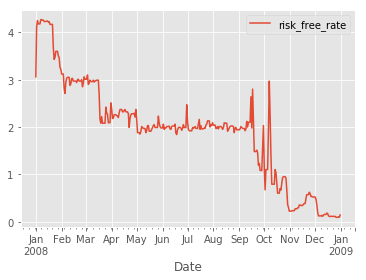

In [39]:
ffr2008.plot()

Suppose we want to restrict to September 2008:

Shape:  (30, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


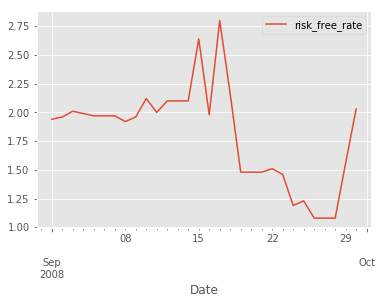

In [41]:
ffr_sep2008 = ffr["2008-09"]
df_info(ffr_sep2008)

ffr_sep2008.plot()

We can use this same functionality to extract ranges of dates. To get the data starting in june 2007 and going until march 2011 we would do

In [42]:
ffr2 = ffr["2007-06":"2011-03"]
df_info(ffr2)

Shape:  (1400, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate
Date,
2007-06-01,5.23
2007-06-02,5.23
2007-06-03,5.23
2011-03-29,0.13
2011-03-30,0.13
2011-03-31,0.10


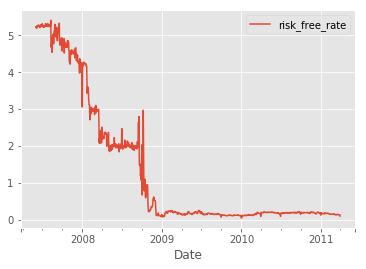

In [43]:
ffr2.plot()

**Exercise (3 min)** Using one of your datasets from quandl, plot one or more variables for the last 3 years (2013 through 2016)

### resampling

Now suppose that instead of daily data, we wanted our federal funds data at a monthly frequency.

To do this we use the `resample` method on our DataFrame

In [44]:
# MS means "month start"
ffrM_resample = ffr.resample("MS")
type(ffrM_resample)

pandas.core.resample.DatetimeIndexResampler

Notice that when we call `resample` we don't get back a DataFrame at that frequency. This is because there is some ambiguity regarding just _how_ the frequency should be converted: should we take the average during the period, the first observation, last observation, sum the observations?

In order to get a DataFrame we have to call a method on our `DatetimeIndexResampler` object. For this example, let's do the first observation in each period:

In [48]:
ffrM = ffrM_resample.first()
df_info(ffrM)

Shape:  (762, 1)
dtypes:  {'risk_free_rate': dtype('float64')}
index dtype:  datetime64[ns]


,risk_free_rate
Date,
1954-07-01,1.13
1954-08-01,0.25
1954-09-01,1.44
2017-10-01,1.06
2017-11-01,1.16
2017-12-01,1.16


In [46]:
ffr.resample?

Note that we can also combine numbers with the specification of the resampling frequency. As an example, we can resample to a bi-weekly frequency using

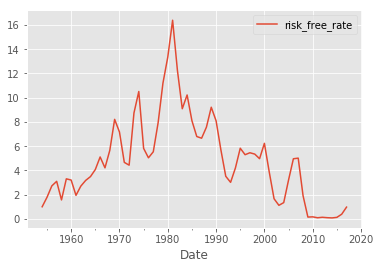

In [62]:
ffr.resample("Y").mean().plot()

**Exercise (5 min)**: Using the [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) for the most common frequencies, figure out how to resample one of your datasets to 

- A quarterly frequency -- make sure to get the _start_ of the quarter
- An annual frequency -- use the end of the _year_

**more than you need**: I want to point out that when you use the `first` or `last` methods to perform the aggregations, there are two dates involved: (1) the date the resultant index will have and (2) the date used to fill in the data at that date. The first date (one on the index) will be assigned based on the string you pass to the `resample` method. The second date (the one for extracting data from the original dataframe) will be determined based on the method used to do the aggregation. `first` will extract the first data point from that subset and `last` will extract the last.

Let's see some examples:

In [57]:
ffr.resample("M").mean().head()

,risk_free_rate
Date,
1954-07-31,0.799355
1954-08-31,1.220645
1954-09-30,1.066667
1954-10-31,0.848710
1954-11-30,0.833667


In [55]:
ffr.resample("MS").mean().head()

,risk_free_rate
Date,
1954-07-01,0.799355
1954-08-01,1.220645
1954-09-01,1.066667
1954-10-01,0.848710
1954-11-01,0.833667


Notice that the index is the same on both, but the data is clearly different.

If we use `MS` instead of `M` we will have the index based on the first day of the month:

In [68]:
ffr.resample("MS").first().head()

,risk_free_rate
Date,
1954-07-01,1.13
1954-08-01,0.25
1954-09-01,1.44
1954-10-01,0.50
1954-11-01,1.38


In [64]:
ffr.resample("MS").last().head()

,risk_free_rate
Date,
1954-07-01,0.25
1954-08-01,1.44
1954-09-01,1.44
1954-10-01,1.13
1954-11-01,1.38


Notice how the data associated with `"M"` and `first` is the same as the data for `"MS"` and `first`. The same holds for `last`.

### Access year, month, day...

Given a `DatetimeIndex` you can access the day, month, or year (also second, millisecond, etc.) by simply accessing the `.XX` property; where `XX` is the data you want

In [69]:
ffr.index.year

Int64Index([1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=23171)

In [70]:
ffr.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30,  1,  2,  3,  4,  5,  6,  7],
           dtype='int64', name='Date', length=23171)

In [71]:
ffr.index.month

Int64Index([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
            ...
            11, 11, 11, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='Date', length=23171)

### Rolling computations

We can use pandas to do rolling computations.

For example, suppose we **want** to plot the maximum and minimum of the risk free rate within the past week at each date (think about that slowly -- for every date, we want to look back 7 days and compute the max).

Here's how we can do that

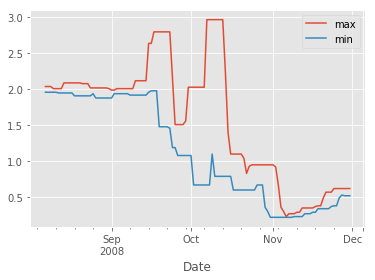

In [84]:
fig, ax = plt.subplots()

ffr["2008-8":"2008-11"].rolling(window=7).max().plot(ax=ax)
ffr["2008-8":"2008-11"].rolling(window=7).min().plot(ax=ax)

ax.legend(["max","min"])

Note that this is different from just resampling because we will have an observation for every date in the original dataframe (except the number of dates at the front needed to construct the initial window).

In [78]:
ffr.rolling(window=7).max().head(10)

,risk_free_rate
Date,
1954-07-01,NaN
1954-07-02,NaN
1954-07-03,NaN
1954-07-04,NaN
1954-07-05,NaN
1954-07-06,NaN
1954-07-07,1.25
1954-07-08,1.25
1954-07-09,1.25


In [79]:
ffr.resample("7D").max().head(10)

,risk_free_rate
Date,
1954-07-01,1.25
1954-07-08,1.25
1954-07-15,0.75
1954-07-22,0.75
1954-07-29,0.38
1954-08-05,1.44
1954-08-12,1.44
1954-08-19,1.44
1954-08-26,1.44


### Merging with dates

Let's see what happens when we merge the ffr and vc datasets

In [ ]:
# do a left merge on the index (date info)
df = pd.merge(ffr, vc, left_index=True, right_index=True, how="left")
df_info(df)

In [ ]:
vc.head()

Notice that we ended up with a lot of missing data. This happened for two reasons:

1. The ffr data goes back to 1954, but the vc data starts in 1985
2. The ffr data is at a daily frequency, but vc is at quarterly.

To resolve the first issue we can subset the ffr data and only keep from 1985 on

In [ ]:
ffr_recent = ffr["1985":]

To resolve the second issue we will do two-steps:

1. resample the `ffr` data to a monthly frequency
2. resample the `vc` data to a monthly frequency by _padding_. This is called upsampling because we are going from a lower frequency (quarterly) to a higher one (monthly)

In [ ]:
ffr_recentM = ffr_recent.resample("M").first()
vc_M = vc.resample("M").pad()

In [ ]:
vc_M.head()

Notice that using `pad` here just copied data forwards to fill in missing months (e.g. the data for March 1985 was applied to April and May)

Now let's try that merge again

In [ ]:
df = pd.merge(ffr_recentM, vc_M, left_index=True, right_index=True, how="left")
print(df.head(6))
print("\n\n", df.tail(8))

That looks much better -- we have missing data at the top and the bottom for months that aren't available in the venture capital dataset, but nothing else should be missing.

Let's try to do something interesting with this data. We **want** to plot the growth rate in the risk free rate, early stage vc funding, and total vc funding for the months following the start of the dotcom boom (rougly Jan 1995) and the housing boom (roughly Jan 2004). 

Read that again carefully. 

For each of the three series we want 2 lines. For each line, the x axis will be quarters since start of boom. The y axis growth rates since first month of bubble.

So we see that these booms were qualitatively different in terms of the response of the risk free rate and venture capital funding.